In [1]:
import numpy as np
import os #ignore - used for debugging
import sys #ignore - used for debugging
import math
import time
import matplotlib.pyplot as plt
from matplotlib import colors
import tracemalloc


In [2]:
def set_seed(seed_value):
    '''
    set seed value to reproduce the results
    input: seed_value
    '''
    np.random.seed(seed_value)

In [3]:
def create_board_randomly(n):
    '''
    creating a board randomnly of dimensions nxn
    placing each queen in a column
    input: n - dimensions (for our assignment - we can set it as 8)
    '''
    return(np.random.randint(0,n,n))

In [4]:
def combination(n):
    return math.comb(n,2)

In [5]:
def attacks(board):
    '''
    calculating the attacks on the queen
    actually there is no need to explicitly track conflicts in the columns - it would be redundant
    this is because we ensure that only one queen occupies every column
    input: we give the board configuration here
    '''
    n = len(board)
    '''
    keeps track of the queens along rows and 2 diagonals (main and secondary)
    '''
    row_count, diagmain_count, diagsecond_count = [0] * n , [0] * 2 * n, [0] * 2 * n
    for i in range(n): #i is every column on the board
        row_count[board[i]] += 1 #board[i] - gives you the row at which the queen is placed at column i
        diagmain_count[i + board[i]] += 1 # sets bound for the diagonal count
        diagsecond_count[i - board[i] + n] += 1 # same as above
    attacks = row_count + diagmain_count + diagsecond_count
    return sum(map(combination, attacks))

In [6]:
def print_board(board):
    '''
    print the board (might be helpful for debugging or for the report)
    '''
    n = len(board)
    display = np.zeros([n,n])
    #making alternate white and black rows and columns -  (odd row, even col and even row, odd col)
    display[1::2, ::2] = 1
    display[::2, 1::2] = 1
    fig, ax = plt.subplots()
    cols = ['white', 'gray']
    cmap = colors.ListedColormap(cols)
    ax.imshow(display, cmap = cmap, norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(n):
        plt.text(i, board[i], u"\u265B", fontsize = 48, horizontalalignment = 'center',verticalalignment = 'center')
    plt.show()
    print(f'queens [L-r] at rows: {board}')
    print(f'attacks: {attacks(board)}')


In [7]:
def steepest_ascent_hill_climbing(board, max_iterations=1000):
    '''
    1. vanilla hill climbing -  chooses 1st neighboring node that brings it closer to the solution
    2. steepest ascent hill climbing - checks all successors and chooses the one that is closest to the solution
        similar to best first search -  explores all available extensions of the current path instead of
        committing to just one
    both versions - face difficulties in the presence of local maxima that are not solutions
    input: board configuration
    '''

    copy_board = board.copy() #create a copy of the board
    which_iteration = 0
    n = len(copy_board)
    for iteration in range(max_iterations):
        #check for  attacks every iteration
        current_attack = attacks(copy_board)
        #track best move and corresponding attacks
        best_move = None
        best_attack = current_attack
        #find best move which minimizes attacks
        for j in range(n):#column
            for i in range(n):# row
                if copy_board[j] != i:
                    temp_board = copy_board.copy()
                    temp_board[j] = i
                    temp_attack = attacks(temp_board)
                    #if move reduces attacks
                    if temp_attack < best_attack:
                        best_attack = temp_attack
                        best_move = (j, i)

        if best_move is not None:
            j, i = best_move
            copy_board[j] = i
            which_iteration = iteration
        else:
            break
    return copy_board, attacks(copy_board), which_iteration #retreive the board and corresponding attacks


In [8]:
def random_restart_hill_climbing(vanilla_function, max_restarts=100):
    '''
    meta version of steepest_ascent_hill_climbing - run hill climbing with a random init condition
    here, looks for best board with no attack
    this means that in a successive iteration if we find a superior board, it compares and then
    replaces the stored board and tries to find the optimal board
    '''
    best_board = None
    best_attack = float('inf')
    best_iteration = 0
    for restart in range(max_restarts): #restart vanilla version 100 times
        #create new random board for every restart
        if best_board is not None:
            board = create_board_randomly(len(best_board))
        else:
            board = create_board_randomly(8)
        result_board, result_attack, which_iteration = vanilla_function(board)
        #find best board if it's having a lesser attack among the queens
        if result_attack < best_attack:
            best_board = result_board
            best_attack = result_attack
            best_iteration = which_iteration
    return best_board, best_attack, best_iteration #retreive the board and corresponding conflicts

In [9]:
def run_experiment(vanilla_or_meta, board_size, name_function, num_runs=10):
    '''
    increase runs but comment print boards (you don't want overflowing output)
    input: function - can be steepest_ascent_hill_climbing (vanilla) or random_restart_hill_climbing (meta)
    '''
    #store values for all runs
    total_runtime, total_attacks, optimal_solutions, total_memory = 0,0,0,0
    append_runtime, append_attacks, append_optimal_Solutions, which_iterations, append_memory  = [],[],[], [], []
    i = 0

    while i < num_runs:
        set_seed(i)
        tracemalloc.start()
        snapshot1 = tracemalloc.take_snapshot()#take a snapshot before solving
        start_time = time.time() #record the start time
        board = create_board_randomly(board_size)
        print('#######################################################################################')
        print(f'Starting run {i+1} for {name_function}')
        #print_board(board) #comment if calculating run time and memory
        result_board, result_attack, result_iteration = vanilla_or_meta(board) #run the function
        #print_board(result_board)#comment if calculating run time and memory
        end_time = time.time() # end the time
        run_time = end_time - start_time #calculate the difference
        snapshot2 = tracemalloc.take_snapshot()#take the final snapshot
        tracemalloc.stop()
        top_stats = snapshot2.compare_to(snapshot1,'lineno')#Calculating the memmory usage
        memory = (top_stats[0].size_diff / 1024)
        total_runtime += run_time
        total_attacks += result_attack
        total_memory += memory
        append_runtime.append(run_time)
        append_attacks.append(result_attack)
        which_iterations.append(result_iteration)
        append_memory.append(memory)
        if result_attack == 0:
            optimal_solutions += 1
            append_optimal_Solutions.append(1)
        else:
            append_optimal_Solutions.append(0)
        print(f'\nEnding {i+1} run')
        print('#######################################################################################\n')
        i += 1
    avg_runtime = total_runtime / num_runs
    avg_memory = total_memory / num_runs
    percent_attacks = (total_attacks / num_runs) * 100
    percent_optimal_solutions = (optimal_solutions / num_runs) * 100
    print('#######################################################################################\n\n')
    return avg_runtime, percent_attacks, percent_optimal_solutions, append_runtime, append_attacks, append_optimal_Solutions, which_iterations, avg_memory, append_memory

In [10]:
def plot_results(steepest_ascent_results, restarts_results):
    metric = ['_','_','_','run_Times', 'attacks', 'optimal solutions']
    for i in {3,4,5}:
        plt.plot(list(range(1, 11)), steepest_ascent_results[i], label='steepest')
        plt.plot(list(range(1, 11)), restarts_results[i], label='random')
        plt.xlabel('runs')
        plt.ylabel(metric[i].capitalize())
        plt.title(f'{metric[i].capitalize()} vs runs')
        plt.legend()
        plt.show()

In [11]:
board_size = 8
steepest_ascent_results = run_experiment(steepest_ascent_hill_climbing, board_size, 'steepest ascent hill climbing')

#######################################################################################
Starting run 1 for steepest ascent hill climbing

Ending 1 run
#######################################################################################

#######################################################################################
Starting run 2 for steepest ascent hill climbing

Ending 2 run
#######################################################################################

#######################################################################################
Starting run 3 for steepest ascent hill climbing

Ending 3 run
#######################################################################################

#######################################################################################
Starting run 4 for steepest ascent hill climbing

Ending 4 run
#######################################################################################

########################################

In [12]:
restarts_results = run_experiment(lambda x: random_restart_hill_climbing(steepest_ascent_hill_climbing), \
                                  board_size, 'random restart hill climbing')

#######################################################################################
Starting run 1 for random restart hill climbing

Ending 1 run
#######################################################################################

#######################################################################################
Starting run 2 for random restart hill climbing

Ending 2 run
#######################################################################################

#######################################################################################
Starting run 3 for random restart hill climbing

Ending 3 run
#######################################################################################

#######################################################################################
Starting run 4 for random restart hill climbing

Ending 4 run
#######################################################################################

############################################

In [13]:
print('HC version\t\tboard size\tavg run time\tavg memory\tattacks% \toptimal solutions% ')
print(f'steepest-ascent\t\t{board_size}\t\t{steepest_ascent_results[0]:.5f}\t\t{steepest_ascent_results[7]:.5f}\t\t{steepest_ascent_results[1]:.2f}\t\t{steepest_ascent_results[2]:.2f}')
print(f'random restarts\t\t{board_size}\t\t{restarts_results[0]:.5f}\t\t{restarts_results[7]:.5f}\t\t{restarts_results[1]:.2f}\t\t{restarts_results[2]:.2f}\n\n')

HC version		board size	avg run time	avg memory	attacks% 	optimal solutions% 
steepest-ascent		8		0.03413		1.49600		120.00		10.00
random restarts		8		3.52111		3.74922		0.00		100.00




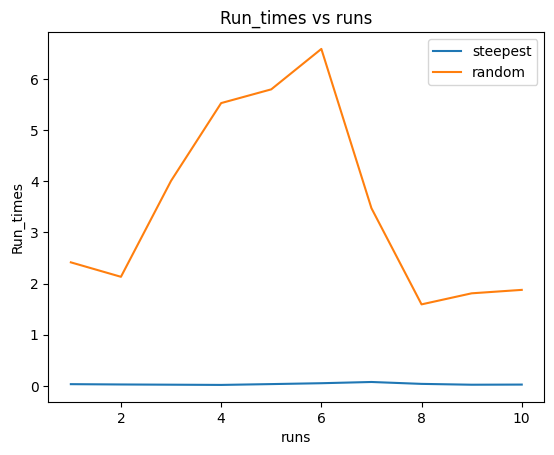

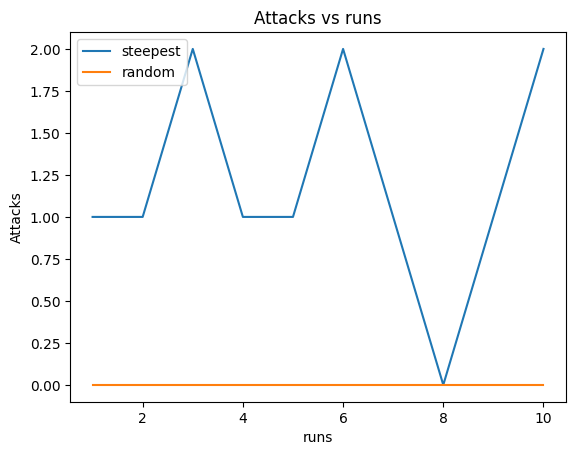

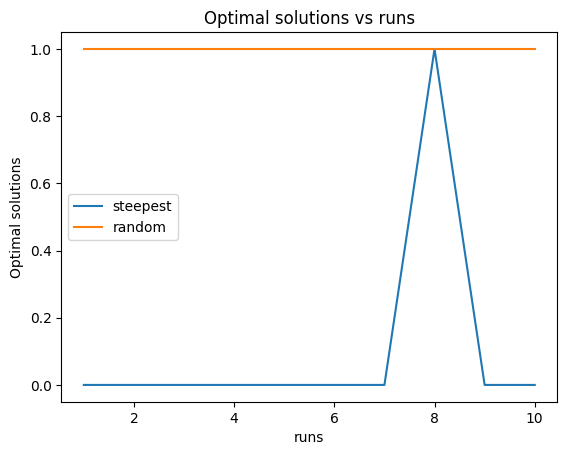

In [14]:
plot_results(steepest_ascent_results, restarts_results)